In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
from matplotlib.lines import Line2D
import seaborn as sns

import numpyro
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

import jax
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
from jax import lax

In [3]:
# # Se the number of CPU cores
# numpyro.set_host_device_count(4)

In [4]:
DATA_PATH = '../data/processed/data_processed.csv'
data = pd.read_csv(DATA_PATH)

In [5]:
data.columns

Index(['Unnamed: 0', 'machineID', 'datetime', 'voltmean_3h', 'rotatemean_3h',
       'pressuremean_3h', 'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h',
       'pressuresd_3h', 'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h',
       'pressuremean_24h', 'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h',
       'pressuresd_24h', 'vibrationsd_24h', 'error1count', 'error2count',
       'error3count', 'error4count', 'error5count', 'comp1', 'comp2', 'comp3',
       'comp4', 'comp1_life', 'comp2_life', 'comp3_life', 'comp4_life', 'age',
       'model_model1', 'model_model2', 'model_model3', 'model_model4',
       'failure', 'comp1_fail', 'comp2_fail', 'comp3_fail', 'comp4_fail'],
      dtype='object')

In [6]:
data['datetime'] = pd.to_datetime(data.datetime)

In [7]:
data_per_id = data.loc[data.machineID==1]

In [8]:
data_cols = ['voltmean_3h', 'rotatemean_3h',
       'pressuremean_3h', 'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h',
       'pressuresd_3h', 'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h',
       'pressuremean_24h', 'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h',
       'pressuresd_24h', 'vibrationsd_24h', 'error1count', 'error2count',
       'error3count', 'error4count', 'error5count','model_model1', 'model_model2', 'model_model3', 'model_model4']

target_cols = ['comp1_life', 'comp2_life', 'comp3_life', 'comp4_life']

In [9]:
N_features = len(data_cols)

In [10]:
data_per_id = data_per_id[data_cols+['comp1_fail']]
data_per_id = data_per_id.dropna()

In [11]:
data_per_id.shape, data_per_id[data_cols].shape

((2913, 26), (2913, 25))

In [12]:
X_df = data_per_id[data_cols]
X = X_df.values

# y_df = [data_per_id[target_col] for target_col in target_cols]

# for df_ in y_df:
#     df_.dropna(inplace=True, axis=0)

In [13]:
a = data_per_id['comp1_fail']


a = a.dropna()
y = a.values

In [14]:
train_size_pc = 0.85
train_idx = np.floor(train_size_pc*X.shape[0]).astype(int)

X_train = X[:train_idx]
X_test = X[train_idx:]

y_train = y[:train_idx]
y_test = y[train_idx:]

In [15]:
N_train = y_train.shape[0]
N_test = y_test.shape[0]

In [16]:
y.shape, X.shape

((2913,), (2913, 25))

In [17]:
# X_train_mean = X_train.mean(axis=0)
# X_train_std = X_train.std(axis=0)

# y_train_mean = y_train.mean(axis=0)
# y_train_std = y_train.std(axis=0)

In [18]:
# X_train[:, :-4] -= X_train_mean[:-4]
# X_train[:, :-4] /= X_train_std[:-4]

# X_test[:, :-4] -= X_train_mean[:-4]
# X_test[:, :-4] /= X_train_std[:-4]



In [19]:
# y_train -= y_train_mean
# y_train /= y_train_std

# y -= y_train_mean
# y /= y_train_std

### Model

In [20]:
def f(carry, inputs):
    
    x = inputs
        
    betas, z_prev, tau, w = carry
    
    z_t = 0
    for i in range(len(betas)):
        z_t += betas[i]* z_prev[i]
        
    z_t += jnp.dot(w, x) #+ tau*noise_t
    
    
#     z_prev_cp = z_prev.copy()
        
#     for i in range(len(z_prev)):
#         if i==0:
#             z_prev[i] = z_t
#         else:
#             z_prev[i] = z_prev_cp[i-1]
    
            
    z_prev_cp = [i for i in range(len(z_prev))]
    
    
    for i in range(len(z_prev)):
        if i==0:
            z_prev_cp[i] = z_t
        else:
            z_prev_cp[i] = z_prev[i-1]
            

    
    return (betas, z_prev_cp, tau, w), z_t

In [21]:
def model(T, T_forecast, obs=None, inputs=None, n_latent=1):
    """ Define priors over beta1, beta2, tau, noises, sigma, z_prev1 and z_prev2 (keep the shapes in mind)
    # Your code here
    """
    
    n,p = inputs.shape
    
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=3.))
    noises = numpyro.sample("noises", fn=dist.Normal(0., 1.), sample_shape=(n,))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=3.))
    
    
    w = numpyro.sample(name="inp_mtrx", fn=dist.Normal(loc=np.zeros(p), scale=5.)) # how to estimate scale?
    
    
#     beta2 = numpyro.sample(name="beta_2", fn=dist.Normal(loc=0., scale=5.))
#     beta1 = numpyro.sample(name="beta_1", fn=dist.Normal(loc=0., scale=5.))
    
    betas = [numpyro.sample(name=f"beta_{i+1}", fn=dist.Normal(loc=0., scale=5.)) for i in range(n_latent)]
    
    
#     z_prev1 = numpyro.sample(name="z_1", fn=dist.Normal(loc=0., scale=3.))
#     z_prev2 = numpyro.sample(name="z_2", fn=dist.Normal(loc=0., scale=3.))
    
    z_prev = [numpyro.sample(name=f"z_{i+1}", fn=dist.Normal(loc=0., scale=5.)) for i in range(n_latent)]
#     z_prev = [numpyro.sample(name=f"z_{i+1}", fn=dist.HalfNormal()) for i in range(n_latent)]
    
        
    """ Propagate the dynamics forward using jax.lax.scan"""
    carry = (betas, z_prev, tau, w)
    z_collection = z_prev[:]
    carry, zs_exp = lax.scan(f, carry,  inputs, T+T_forecast-n_latent)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    
    
    """ Sample the observed_y (y_obs) and predicted_y (y_pred)"""
    
    
    numpyro.sample(name="y_obs", fn=dist.Normal(loc=z_collection[:T], scale=sigma), obs=obs[:T])
    numpyro.sample(name="y_pred", fn=dist.Normal(loc=z_collection[T:], scale=sigma), obs=None)
    return z_collection

In [22]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

n_latent = 2
T = N_train
T_forecast = N_test

X_t = np.concatenate([X_train[n_latent:,:], X_test], axis=0)


nuts_kernel = NUTS(model=model, max_tree_depth=8, step_size=5e-3, adapt_step_size=False)
mcmc = MCMC(nuts_kernel, num_samples=3000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=T, T_forecast=T_forecast, inputs=X_t, obs=y, n_latent=n_latent)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
sample: 100%|█| 4000/4000 [04:18<00:00, 15.49it/s, 255 steps of size 5.00e-03. acc


In [23]:
mcmc.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta_1     -0.97      0.05     -0.98     -1.04     -0.90      2.52      4.00
      beta_2     -0.53      0.06     -0.54     -0.61     -0.45      2.65      2.53
 inp_mtrx[0]      0.00      0.00      0.00     -0.00      0.00    164.85      1.02
 inp_mtrx[1]     -0.00      0.00     -0.00     -0.00      0.00    118.47      1.04
 inp_mtrx[2]      0.00      0.00      0.00     -0.00      0.00   2609.84      1.00
 inp_mtrx[3]     -0.00      0.00     -0.00     -0.00      0.00     40.92      1.07
 inp_mtrx[4]      0.00      0.00      0.00      0.00      0.00     61.18      1.06
 inp_mtrx[5]     -0.00      0.00     -0.00     -0.00      0.00     23.15      1.05
 inp_mtrx[6]     -0.00      0.00     -0.00     -0.00      0.00     78.96      1.02
 inp_mtrx[7]     -0.00      0.01     -0.00     -0.01      0.01      7.09      1.24
 inp_mtrx[8]      0.01      0.00      0.01      0.01      0.02    136.60      1.00
 in

In [24]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}

In [25]:
q = hmc_samples["y_pred"]
q_mean = q.mean(axis=0).reshape(-1,)
q_std = q.std(axis=0).reshape(-1,)
y_pred_025 = q_mean - 1.96*q_std
y_pred_975 = q_mean + 1.96*q_std
y_pred_mean = q_mean

In [26]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

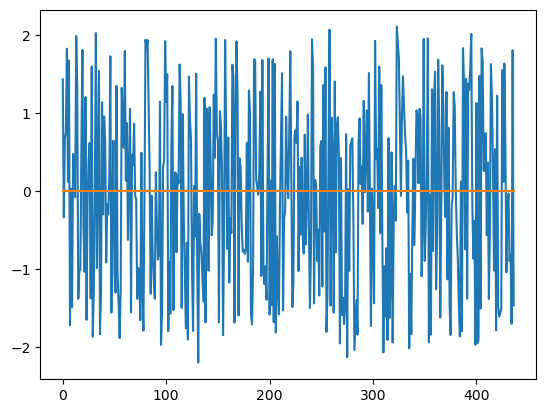

In [35]:
plt.plot(y_pred_mean)
plt.plot(y[T:])

In [28]:
y_pred_mean.shape, y_test.shape

((437,), (437,))

In [29]:
a = np.array([i for i in range(10)])

In [30]:
b = a
for i in range(len(a)):
        if i==0:
            b[i] = 100
        else:
            b[i] = a[i-1]

In [31]:
a, b

(array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100]),
 array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100]))

In [32]:
len(a), len(b)

(10, 10)